# Classification on MNIST Dataset using `pytorch`

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from helper_functions import train_classification
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


In [2]:
plt.style.use(
    [
        f"../mplstyles/{style}.mplstyle"
        for style in ["grid", "science", "notebook", "mylegend"]
    ],
)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using {device} device")

Using cpu device


## Load data

In [4]:
training_data = datasets.MNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor(),
)

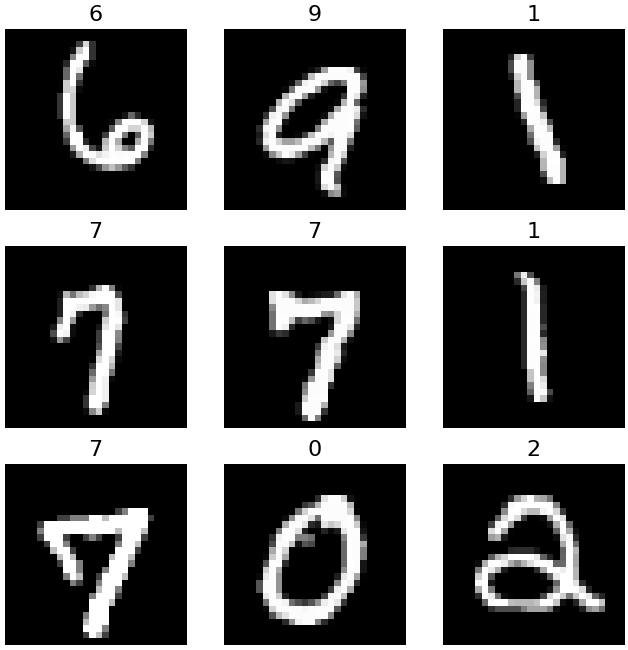

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = int(torch.randint(len(training_data), size=(1,)).item())
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Data preprocessing

In [6]:
training_data.data = training_data.data / 255.0
test_data.data = test_data.data / 255.0

## Training

In [39]:
NUM_EPOCHS = 100
LEARNING_RATE = 1e-2
BATCH_SIZE = 128
INPUT_SIZE = 28 * 28
NUM_CLASSES = 10
SAVEFIG = True

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

### Linear model benchmark

In [40]:
lin_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(INPUT_SIZE, NUM_CLASSES),
    nn.Sigmoid(),
).to(device)

In [41]:
lin_train_losses, lin_test_losses, lin_accuracies = train_classification(
    lin_model,
    train_dataloader,
    test_dataloader,
    LEARNING_RATE,
    NUM_EPOCHS,
)

### Neural Network

In [42]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim: int, output_dim: int) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [43]:
nn_model = NeuralNetwork(INPUT_SIZE, NUM_CLASSES).to(device)
print(nn_model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [44]:
nn_train_losses, nn_test_losses, nn_accuracies = train_classification(
    nn_model,
    train_dataloader,
    test_dataloader,
    LEARNING_RATE,
    NUM_EPOCHS,
)

## Plotting

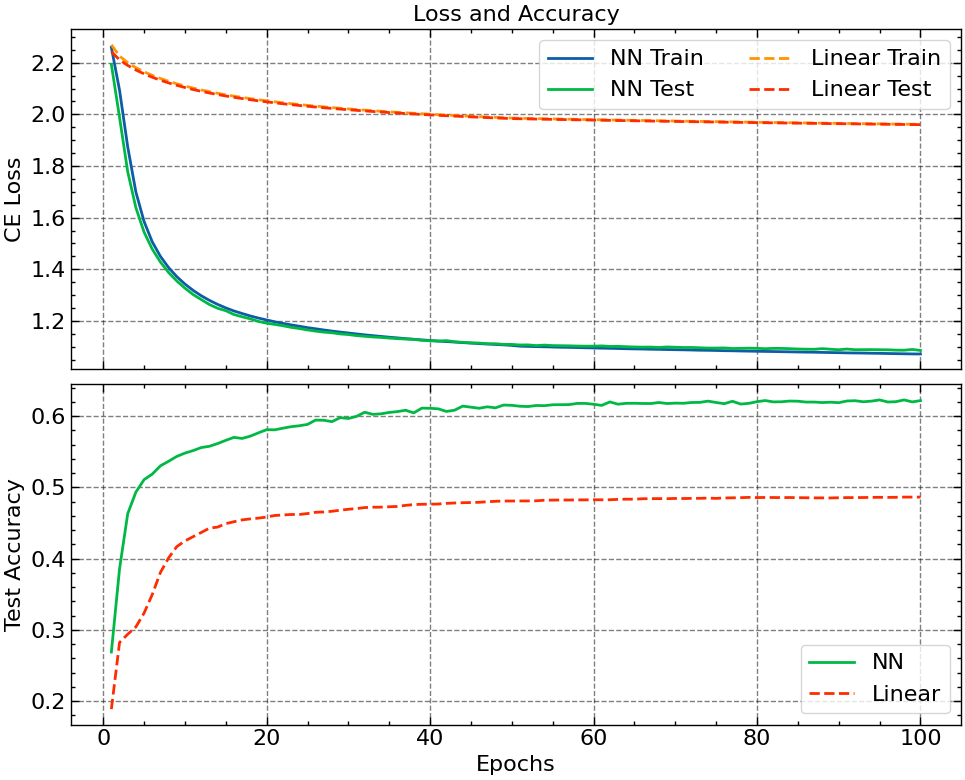

In [45]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

ax = axes[0]
ax.plot(range(1, NUM_EPOCHS + 1), nn_train_losses, label="NN Train")
ax.plot(range(1, NUM_EPOCHS + 1), nn_test_losses, label="NN Test")
ax.plot(
    range(1, NUM_EPOCHS + 1),
    lin_train_losses,
    label="Linear Train",
    linestyle="--",
)
ax.plot(range(1, NUM_EPOCHS + 1), lin_test_losses, label="Linear Test", linestyle="--")

ax.set_title("Loss and Accuracy")
ax.set_ylabel("CE Loss")

ax.legend(ncols=2)

ax = axes[1]
ax.plot(range(1, NUM_EPOCHS + 1), nn_accuracies, label="NN", color=colors[1])
ax.plot(
    range(1, NUM_EPOCHS + 1),
    lin_accuracies,
    label="Linear",
    linestyle="--",
    color=colors[3],
)

ax.set_xlabel("Epochs")
ax.set_ylabel("Test Accuracy")

ax.legend()

fig.tight_layout()
plt.show()

if SAVEFIG:
    fig.savefig(
        f"./images/pytorch_class_loss_acc_{NUM_EPOCHS}_{LEARNING_RATE}_{BATCH_SIZE}.png",
        dpi=200,
    )

In [46]:
def get_num_classes(dataloader: DataLoader) -> int:
    num_classes = 0
    for _, labels in dataloader:
        num_classes = max(num_classes, labels.max().item() + 1)
    return num_classes


def confusion_matrix(model: nn.Module, test_dataloader: DataLoader) -> torch.Tensor:
    num_classes = get_num_classes(test_dataloader)
    conf_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    model.eval()
    with torch.no_grad():
        for images, labels in test_dataloader:
            images[:], labels[:] = images.to(device), labels.to(device)
            preds = torch.argmax(model(images), dim=1)
            for t, p in zip(labels, preds, strict=True):
                conf_matrix[t, p] += 1

    return conf_matrix

In [47]:
linear_conf_matrix = confusion_matrix(lin_model, test_dataloader)
nn_conf_matrix = confusion_matrix(nn_model, test_dataloader)

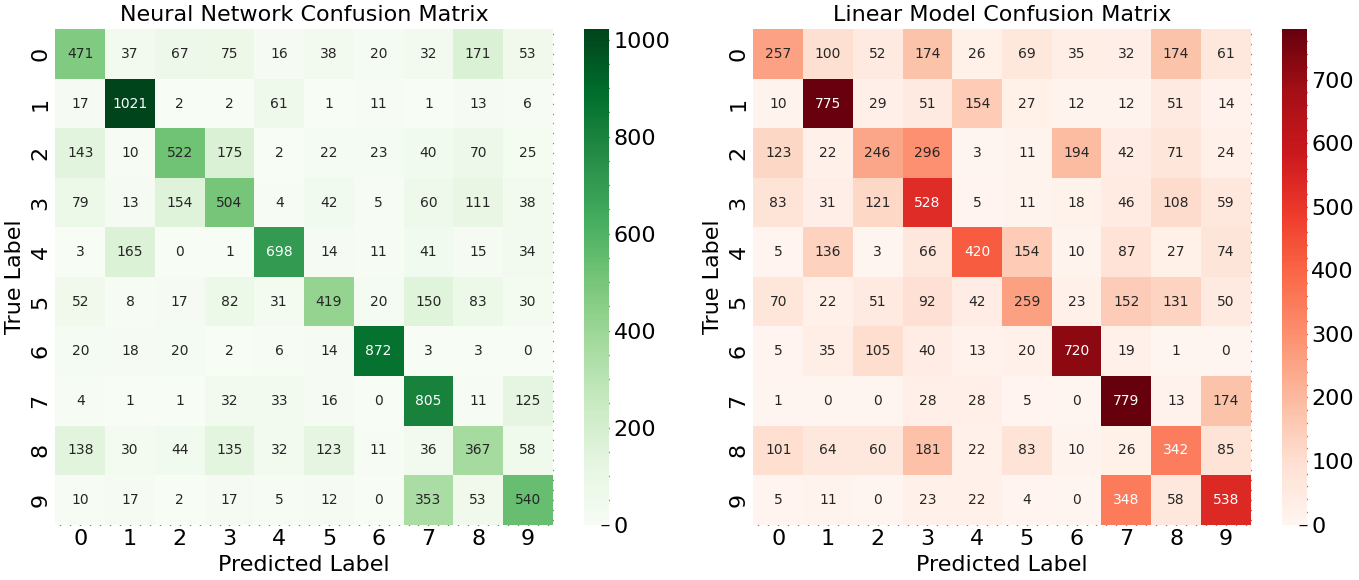

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
sns.heatmap(nn_conf_matrix, annot=True, fmt="d", ax=ax, cmap="Greens")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Neural Network Confusion Matrix")

ax = axes[1]
sns.heatmap(linear_conf_matrix, annot=True, fmt="d", ax=ax, cmap="Reds")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Linear Model Confusion Matrix")

fig.tight_layout()
plt.show()

if SAVEFIG:
    fig.savefig(
        f"./images/pytorch_class_conf_matrix_{NUM_EPOCHS}_{LEARNING_RATE}_{BATCH_SIZE}.png",
        dpi=200,
    )